In [848]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn import tree, metrics
from sklearn.tree import _tree
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.metrics import PrecisionRecallDisplay, f1_score, average_precision_score, roc_curve, precision_recall_fscore_support, precision_recall_curve, confusion_matrix, classification_report

In [849]:
def getWeights_FFD(d,thres):
    w,k=[1.],1
    while True:
        w_=-w[-1]/k*(d-k+1)
        if abs(w_)<thres:break
        w.append(w_);k+=1
    return np.array(w[::-1]).reshape(-1,1)

def fracDiff_FFD(series,d,thres=1e-5):
    # Constant width window (new solution)
    w=getWeights_FFD(d,thres)
    df={}
    for name in series.columns:
        df_= pd.Series(series[name].values,index=series.index).ffill().dropna()
        x = pd.Series(0,index=df_.index)
        for k in range(w.shape[0]):
            x = x+w[k,0]*df_.shift(-k)
    #df[name]=x.dropna().copy(deep=True)
    df[name]=x.shift(k).copy(deep=True)
    df=pd.concat(df,axis=1)
    return df

def findMinD(series):
    for d in np.linspace(0,1,11):
        df_=fracDiff_FFD(series,d,thres=0.01).dropna()
        res=adfuller(df_.iloc[:,0].values,maxlag=1,regression='c',autolag=None)
        if (res[0]<=res[4]['5%']):
            return d
    return 1.0

In [850]:
monthlydf = pd.read_excel('./PredictorData2019.xlsx', sheet_name='Monthly')
quarterlydf = pd.read_excel('./PredictorData2019.xlsx', sheet_name='Quarterly')
annualdf = pd.read_excel('./PredictorData2019.xlsx', sheet_name='Annual')   

c:\Users\tkkim\AppData\Local\Programs\Python\Python39\lib\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")
c:\Users\tkkim\AppData\Local\Programs\Python\Python39\lib\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")
c:\Users\tkkim\AppData\Local\Programs\Python\Python39\lib\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


In [851]:
def calced_cols(df): 
    #dividend price ratio
    df['dp'] = np.log(df['D12']) - np.log(df['Index'])

    #dividend yield
    df['dy'] = np.log(df['D12']) - np.log(df['Index'].shift(-1))

    #earnings price ratio
    df['ep'] = np.log(df['E12']) - np.log(df['Index'])

    
    #10 year e/p ratio
    if 'yyyymm' in df.columns:
        df['ep10'] = np.log(df['E12'].rolling(120).mean()) - np.log(df['Index'])
    elif 'yyyyq' in df.columns:
        df['ep10'] = np.log(df['E12'].rolling(40).mean()) - np.log(df['Index'])
    else:
        df['ep10'] = np.log(df['E12'].rolling(10).mean()) - np.log(df['Index'])

    #dividend payout ratio
    df['de'] = np.log(df['D12']) - np.log(df['E12'])

    #default yield spread
    df['dfy'] = df['BAA'] - df['AAA']

    #term spread
    df['tms'] = df['lty'] - df['tbl']

    #default return spread
    df['dfr'] = df['corpr'] - df['lty']
    
    #target with dividend
    df['target'] = df['CRSP_SPvw'] - df['Rfree'] 
    return df




In [852]:
calced_monthly = calced_cols(monthlydf)
calced_quarterly = calced_cols(quarterlydf)
calced_yearly = calced_cols(annualdf)

## Question 1

You will need to refer to: Goyal, Amit, and Ivo Welch. “A Comprehensive Look at the Empirical Performance of Equity Premium Prediction.” The Review of Financial Studies 21, no. 4 (2008): 1455–1508 for the accompanying paper that explains what the features are. 

Use this Predictor 2019 dataset Download this Predictor 2019 dataset.

Create appropriate labels and perform EDA on it. Are there any outliers? (16 points)

There are some outliers in Index, D12, and E12 which makes sense since the overall time span is huge. I'd ignore these as we can imagine stocks only go up (if we zoom out from day one of the data like in the chart directly below, we'll see it trends upwards. So as more data points get added, the number of outliers will stay consistent. That is also why you don't really see the % change across year/quarter/month). Stock variance might need to be ignored too, considering it's calculate off returns.

Inflation also has some interesting outliers. But overall it remains between -0.2 and 0.2. 


<Axes: xlabel='yyyymm'>

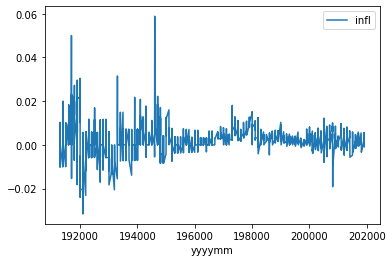

In [853]:
calced_monthly.plot(x='yyyymm',y='infl')

<Axes: xlabel='yyyy'>

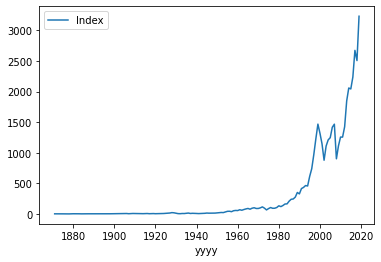

In [854]:
calced_yearly.plot(x='yyyy',y='Index')

<Axes: >

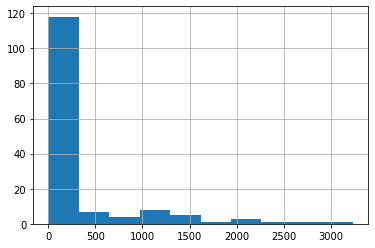

In [855]:
calced_yearly['Index'].hist()

In [856]:
df_list = {'monthly':calced_monthly, 
           'quarterly':calced_quarterly, 
           'yearly':calced_yearly}

In [857]:
# outliers based on 1.5*IQR
def outlier_calcs(df, name):
    bigholder = []
    for col in df.columns:
        smallholder = {}
        if 'yyyy' in col:
            continue
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1
        smallholder['df'] = name
        smallholder['col'] = col
        smallholder['count'] = df[(df[col] <= q1 - 1.5*iqr) | (df[col] >= q3 + 1.5*iqr)][col].count()
        smallholder['outlier_pct'] = smallholder['count']/len(df)
        smallholder['fill_rate'] = 1 - (df[col].isna().sum()/len(df))
        bigholder.append(smallholder)
    
    newdf = pd.DataFrame(bigholder)
    return newdf

In [858]:
outlier_df = pd.DataFrame()
for key, value in df_list.items():
    holder_df = outlier_calcs(value, key)
    outlier_df = pd.concat([outlier_df, holder_df], axis=0)

In [859]:
outlier_df[outlier_df['df'] == 'yearly']

,df,col,count,outlier_pct,fill_rate
0,yearly,Index,30,0.201342,1.000000
1,yearly,D12,18,0.120805,1.000000
2,yearly,E12,21,0.140940,1.000000
3,yearly,b/m,1,0.006711,0.664430
4,yearly,tbl,2,0.013423,0.671141
5,yearly,AAA,3,0.020134,0.677852
6,yearly,BAA,3,0.020134,0.677852
7,yearly,lty,1,0.006711,0.671141
8,yearly,cay,0,0.000000,0.503356
9,yearly,ntis,6,0.040268,0.630872


In [860]:
outlier_df[outlier_df['df'] == 'quarterly']

,df,col,count,outlier_pct,fill_rate
0,quarterly,Index,120,0.201342,1.000000
1,quarterly,D12,70,0.117450,1.000000
2,quarterly,E12,82,0.137584,1.000000
3,quarterly,b/m,3,0.005034,0.664430
4,quarterly,tbl,8,0.013423,0.671141
5,quarterly,AAA,10,0.016779,0.677852
6,quarterly,BAA,14,0.023490,0.677852
7,quarterly,lty,10,0.016779,0.671141
8,quarterly,cay,0,0.000000,0.456376
9,quarterly,ntis,22,0.036913,0.625839


In [861]:
outlier_df[outlier_df['df'] == 'monthly']

,df,col,count,outlier_pct,fill_rate
0,monthly,Index,361,0.201902,1.000000
1,monthly,D12,209,0.116890,1.000000
2,monthly,E12,243,0.135906,1.000000
3,monthly,b/m,10,0.005593,0.663311
4,monthly,tbl,26,0.014541,0.670582
5,monthly,AAA,26,0.014541,0.677852
6,monthly,BAA,40,0.022371,0.677852
7,monthly,lty,36,0.020134,0.671141
8,monthly,ntis,61,0.034116,0.624720
9,monthly,Rfree,44,0.024609,1.000000


## Question 2

Are there any features that are not stationary? If so, fractionally differentiate them. (16 points)


In [862]:
log_columns = ['yyyy','yyyymm','yyyyq','ep','dp','dy','de', 'ep10', 'target']

<Axes: >

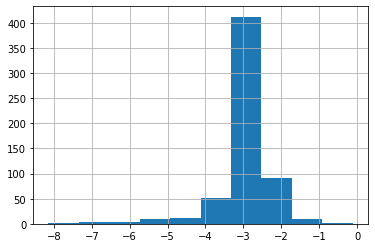

In [863]:
log_imputed_list['quarterly']['CRSP_SPvw'].hist()

In [864]:
def impute(df):
    imputer = IterativeImputer(n_nearest_features=None, imputation_order='ascending')
    imputer.fit(df.iloc[:,1:])
    imputed = imputer.transform(df.iloc[:,1:])
    imputed = pd.concat([df.iloc[:,0:1],pd.DataFrame(imputed)], axis=1)
    colholder = []
    for col in imputer.feature_names_in_.tolist():
        if col in df.columns.to_list():
            colholder.append(col)
    addedcolholder = ['date'] + colholder
    imputed.columns = addedcolholder
    imputed
    df2 = imputed.copy()
    return df2


In [865]:
def logdf(df):
    df2 = df.copy()
    df2.loc[:, ~df2.columns.isin(log_columns)] = np.log(df2.loc[:, ~df2.columns.isin(log_columns)])
    df2.replace([np.inf, -np.inf], np.nan, inplace=True)
    return df2

In [866]:
calced_monthly_log = logdf(calced_monthly)
calced_yearly_log = logdf(calced_yearly)
calced_quarterly_log = logdf(calced_quarterly)

c:\Users\tkkim\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\internals\blocks.py:402: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
c:\Users\tkkim\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\internals\blocks.py:402: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


In [867]:
calced_monthly_log_imputed = impute(calced_monthly_log)
calced_quarterly_log_imputed = impute(calced_quarterly_log) 
calced_yearly_log_imputed = impute(calced_yearly_log)

c:\Users\tkkim\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\impute\_iterative.py:800: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [868]:
def check_if_stationaryv2(df, name):
    bigholder = []
    big_val_holder = df[['date']]
    df_cols = df.columns.to_list()
    
    df_cols.remove('date')
    for col in df_cols:
        
        smallholder = {}
        if 'yyyy' in col:
            continue
        else:
            smallholder['df'] = name
            smallholder['col'] = col
            if findMinD(df[[col]]) <= 0.0:
                smallholder['d_val'] = 0.0
                smallholder['stationary'] = True
                results = adfuller(df[col].dropna(), maxlag=1, regression='c', autolag=None)
                smallholder['crit'] = results[0]
                smallholder['pval'] = results[1]
                smallholder['5%_sig'] = results[4]['5%']
                smallholder['d_val'] = findMinD(df[[col]])
                smallholder['shape'] = len(df[col])
                big_val_holder = big_val_holder.merge(df[[col]], how='left', left_index=True, right_index=True)
                
            else:
                smallholder['d_val'] = findMinD(df[[col]])
                d = findMinD(df[[col]])
                df_ = fracDiff_FFD(df[[col]],d,thres=0.01).dropna()
                results = adfuller(df_[col].dropna(), maxlag=1, regression='c', autolag=None)
                smallholder['stationary'] = False
                smallholder['differentiated'] = True
                smallholder['fd_crit'] =  results[0]
                smallholder['fd_pval'] =  results[1]
                smallholder['fd_5%_sig'] =  results[4]['5%']
                smallholder['shape'] = df_.shape[0]
                big_val_holder = big_val_holder.merge(df_, how='left', left_index=True, right_index=True)
            bigholder.append(smallholder)
    
    newdf = pd.DataFrame(bigholder)
    #transform_df = pd.DataFrame()

   # return newdf, transform_df
    return newdf, big_val_holder

In [869]:
"""def check_if_stationaryv3(df, name):
    bigholder = []
    for col in df.columns:
        smallholder = {}
        if 'yyyy' in col:
            continue
        smallholder['df'] = name
        smallholder['col'] = col
        if findMinD(logtransform(df, col)) <= 0.0:
            smallholder['d_val'] = 1.0
            smallholder['no_transform_stationary'] = True
            results = adfuller(logtransform(df, col).dropna(), maxlag=1, regression='c', autolag=None)
            smallholder['crit'] = results[0]
            smallholder['pval'] = results[1]
            smallholder['5%_sig'] = results[4]['5%']
        else:
            smallholder['d_val'] = findMinD(logtransform(df, col))
            d = findMinD(logtransform(df, col))
            df_ = fracDiff_FFD(logtransform(df, col),d,thres=0.01).dropna()
            results = adfuller(df_[col+'_log'].dropna(), maxlag=1, regression='c', autolag=None)
            smallholder['no_transform_stationary'] = False
            smallholder['fd_doublediff'] = True
            smallholder['fd_crit'] =  results[0]
            smallholder['fd_pval'] =  results[1]
            smallholder['fd_5%_sig'] =  results[4]['5%']
        bigholder.append(smallholder)
    
    newdf = pd.DataFrame(bigholder)
    return newdf    """

"def check_if_stationaryv3(df, name):\n    bigholder = []\n    for col in df.columns:\n        smallholder = {}\n        if 'yyyy' in col:\n            continue\n        smallholder['df'] = name\n        smallholder['col'] = col\n        if findMinD(logtransform(df, col)) <= 0.0:\n            smallholder['d_val'] = 1.0\n            smallholder['no_transform_stationary'] = True\n            results = adfuller(logtransform(df, col).dropna(), maxlag=1, regression='c', autolag=None)\n            smallholder['crit'] = results[0]\n            smallholder['pval'] = results[1]\n            smallholder['5%_sig'] = results[4]['5%']\n        else:\n            smallholder['d_val'] = findMinD(logtransform(df, col))\n            d = findMinD(logtransform(df, col))\n            df_ = fracDiff_FFD(logtransform(df, col),d,thres=0.01).dropna()\n            results = adfuller(df_[col+'_log'].dropna(), maxlag=1, regression='c', autolag=None)\n            smallholder['no_transform_stationary'] = False\n  

In [870]:
log_imputed_list = {'monthly':calced_monthly_log_imputed, 
           'quarterly':calced_quarterly_log_imputed, 
           'yearly':calced_yearly_log_imputed}

In [871]:
stationarity_df = pd.DataFrame()
listofvals = {}
for key, value in log_imputed_list.items():
    print(key)
    holder_df, tempvalholder = check_if_stationaryv2(value, key)
    listofvals[key] = tempvalholder
    stationarity_df = pd.concat([stationarity_df, holder_df], axis=0)

monthly
quarterly
yearly


In [872]:
stationarity_df[stationarity_df['df'] == 'yearly']

,df,col,d_val,stationary,differentiated,fd_crit,fd_pval,fd_5%_sig,shape,crit,pval,5%_sig
0,yearly,Index,0.7,False,True,-3.856145,0.002382,-2.882266,143,NaN,NaN,NaN
1,yearly,D12,0.7,False,True,-3.597564,0.005808,-2.882266,143,NaN,NaN,NaN
2,yearly,E12,0.5,False,True,-3.480445,0.008504,-2.882722,140,NaN,NaN,NaN
3,yearly,b/m,0.2,False,True,-3.493279,0.008161,-2.882878,139,NaN,NaN,NaN
4,yearly,tbl,0.1,False,True,-3.027621,0.032394,-2.882416,142,NaN,NaN,NaN
5,yearly,AAA,0.5,False,True,-3.436850,0.009765,-2.882722,140,NaN,NaN,NaN
6,yearly,BAA,0.3,False,True,-3.090901,0.027234,-2.883037,138,NaN,NaN,NaN
7,yearly,lty,0.4,False,True,-3.707570,0.004008,-2.882878,139,NaN,NaN,NaN
8,yearly,cay,0.0,True,NaN,NaN,NaN,NaN,149,-6.322313,3.044923e-08,-2.88141
9,yearly,ntis,0.0,True,NaN,NaN,NaN,NaN,149,-5.196354,8.944046e-06,-2.88141


In [873]:
stationarity_df[stationarity_df['df'] == 'quarterly']

,df,col,d_val,stationary,differentiated,fd_crit,fd_pval,fd_5%_sig,shape,crit,pval,5%_sig
0,quarterly,Index,0.7,False,True,-3.924530,0.001862,-2.866468,590,NaN,NaN,NaN
1,quarterly,D12,0.9,False,True,-3.052568,0.030268,-2.866443,593,NaN,NaN,NaN
2,quarterly,E12,0.5,False,True,-3.720696,0.003831,-2.866493,587,NaN,NaN,NaN
3,quarterly,b/m,0.1,False,True,-2.920711,0.042992,-2.866476,589,NaN,NaN,NaN
4,quarterly,tbl,0.0,True,NaN,NaN,NaN,NaN,596,-3.391780,1.124232e-02,-2.866418
5,quarterly,AAA,0.3,False,True,-2.868642,0.049118,-2.866510,585,NaN,NaN,NaN
6,quarterly,BAA,0.3,False,True,-3.210561,0.019381,-2.866510,585,NaN,NaN,NaN
7,quarterly,lty,0.3,False,True,-3.898243,0.002048,-2.866510,585,NaN,NaN,NaN
8,quarterly,cay,0.0,True,NaN,NaN,NaN,NaN,596,-5.127882,1.231773e-05,-2.866418
9,quarterly,ntis,0.0,True,NaN,NaN,NaN,NaN,596,-6.493881,1.207727e-08,-2.866418


In [874]:
stationarity_df[stationarity_df['df'] == 'monthly']

,df,col,d_val,stationary,differentiated,fd_crit,fd_pval,fd_5%_sig,shape,crit,pval,5%_sig
0,monthly,Index,0.6,False,True,-2.874169,4.843535e-02,-2.863167,1780,NaN,NaN,NaN
1,monthly,D12,1.0,False,True,-10.282669,3.744142e-18,-2.863161,1787,NaN,NaN,NaN
2,monthly,E12,0.8,False,True,-3.809760,2.809024e-03,-2.863164,1783,NaN,NaN,NaN
3,monthly,b/m,0.1,False,True,-3.009585,3.400893e-02,-2.863166,1781,NaN,NaN,NaN
4,monthly,tbl,0.0,True,NaN,NaN,NaN,NaN,1788,-3.503408,7.899996e-03,-2.86316
5,monthly,AAA,0.3,False,True,-3.031889,3.202180e-02,-2.863170,1777,NaN,NaN,NaN
6,monthly,BAA,0.3,False,True,-3.720327,3.836155e-03,-2.863170,1777,NaN,NaN,NaN
7,monthly,lty,0.3,False,True,-4.058281,1.134273e-03,-2.863170,1777,NaN,NaN,NaN
8,monthly,ntis,0.0,True,NaN,NaN,NaN,NaN,1788,-12.833655,5.801936e-24,-2.86316
9,monthly,Rfree,0.0,True,NaN,NaN,NaN,NaN,1788,-3.534632,7.140953e-03,-2.86316


## Question 3
Follow the steps to respond to this question:

Use the first two-thirds of the data as the train set.

Set your random seed to 1.

Train a random forest using Scikit-learn’s RandomForestClassifier using the default hyperparameters.

Based on the results, what is the predictive accuracy, F1, and AUC score on the train set and the test set? (24 points)


| model     |   precision_train |   recall_train |   f1_train |   auc_train |   precision_test |   recall_test |   f1_test |   auc_test |
|:----------|------------------:|---------------:|-----------:|------------:|-----------------:|--------------:|----------:|-----------:|
| monthly   |                 1 |              1 |          1 |           1 |         0.950739 |      0.901869 |  0.925659 |   0.927912 |
| quarterly |                 1 |              1 |          1 |           1 |         0.903614 |      0.892857 |  0.898204 |   0.878227 |
| yearly    |                 1 |              1 |          1 |           1 |         0.88     |      0.956522 |  0.916667 |   0.872989 |


In [875]:
#impute to fix nans
final_monthlydf = listofvals['monthly']
final_monthlydf_imputed = impute(final_monthlydf)
final_monthlydf_imputed
#1926 first date for excess premium in these data sets
final_quarterlydf = listofvals['quarterly'][listofvals['quarterly']['date'] >= 19261]
final_yearlydf = listofvals['yearly'][listofvals['yearly']['date'] >= 1926]

c:\Users\tkkim\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\impute\_iterative.py:800: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [876]:
np.random.seed(1)

In [877]:
class rfmodel:
    # on creation
    def __init__(self, name, data):
        self.name = name
        self.xdata = data.copy().drop('target', axis=1)
        #dividends included is the target
        self.ydataraw = data['target'].copy()
        #any target giving > 0 returns is a good enough trade
        #also helps with balance without needing to do SMOTE or something to fix imbalance
        self.splitpoint = 0
        self.ydata = np.where(self.ydataraw > self.splitpoint, 1, 0)
 
        self.X_Train, self.X_Test, self.Y_Train, self.Y_Test = train_test_split(self.xdata, self.ydata, test_size=(1/3), random_state=1)
        self.model = RandomForestClassifier(random_state=1)

    def fit(self):
        self.model = self.model.fit(self.X_Train,self.Y_Train)
        self.Y_Pred_Train = self.model.predict(self.X_Train)
        self.Y_Pred_Test = self.model.predict(self.X_Test)
        self.train_probs = self.model.predict_proba(self.X_Train)
        self.test_probs = self.model.predict_proba(self.X_Test)
        self.train_probs = self.train_probs[:,1]
        self.test_probs = self.test_probs[:,1]
        self.precision_train, self.precision_train, self.train_threshold = metrics.precision_recall_curve(self.Y_Train, self.train_probs)
        self.precision_test, self.precision_test, self.test_threshold = metrics.precision_recall_curve(self.Y_Test, self.test_probs)
        self.auc_train = average_precision_score(self.Y_Train, self.Y_Pred_Train)
        self.auc_test = average_precision_score(self.Y_Test, self.Y_Pred_Test)

    def getAccuracy(self):
        self.train_acc = metrics.accuracy_score(self.Y_Train, self.Y_Pred_Train)
        self.test_acc = metrics.accuracy_score(self.Y_Test, self.Y_Pred_Test)
        self.f1_train = f1_score(self.Y_Train, self.Y_Pred_Train)
        self.f1_test = f1_score(self.Y_Test, self.Y_Pred_Test)
        self.bigscoretest = precision_recall_fscore_support(self.Y_Test, self.Y_Pred_Test, average='binary')
        self.bigscoretrain = precision_recall_fscore_support(self.Y_Train, self.Y_Pred_Train, average='binary')

    def makePRplot(self):
        
        self.plot1 = PrecisionRecallDisplay.from_predictions(self.Y_Test, self.Y_Pred_Test, drawstyle="default")
        self.plot1.ax_.set_title(self.name + " Test Precision Recall Curve")
        self.plot2 = PrecisionRecallDisplay.from_predictions(self.Y_Train, self.Y_Pred_Train, drawstyle="default")
        self.plot2.ax_.set_title(self.name + " Train Precision Recall Curve")
        #plt.show()



In [878]:
model_list = {'monthly':final_monthlydf_imputed,
              'quarterly':final_quarterlydf,
              'yearly':final_yearlydf}      
reg_model_list = {}

In [879]:
for key, value in model_list.items():
    model = rfmodel(key, value)
    model.fit()
    model.getAccuracy()
    
    reg_model_list[key] = model

reg_stats_holder = []
for key, value in reg_model_list.items():
    smallholder = {}
    smallholder['model'] = key
    smallholder['precision_train'] = value.bigscoretrain[0]
    smallholder['recall_train'] = value.bigscoretrain[1]
    smallholder['f1_train'] = value.bigscoretrain[2]
    smallholder['auc_train'] = value.auc_train
    smallholder['precision_test'] = value.bigscoretest[0]
    smallholder['recall_test'] = value.bigscoretest[1]
    smallholder['f1_test'] = value.bigscoretest[2]
    smallholder['auc_test'] = value.auc_test
    reg_stats_holder.append(smallholder)

reg_stats_df = pd.DataFrame(reg_stats_holder)


### Untuned Quarterly

test results
 precision test 0.9036144578313253
 recall test 0.8928571428571429
 f1 test 0.8982035928143712
 support test None
-----------------------------------------------------
train results
 precision train 1.0
 recall train 1.0
 f1 train 1.0
 support train None


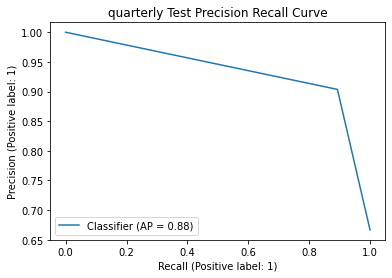

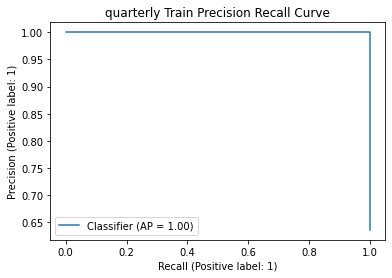

In [880]:
# plot PR Curve
reg_model_list["quarterly"].makePRplot()
print('test results')
print(f' precision test {reg_model_list["quarterly"].bigscoretest[0]}')
print(f' recall test {reg_model_list["quarterly"].bigscoretest[1]}')
print(f' f1 test {reg_model_list["quarterly"].bigscoretest[2]}')
print(f' support test {reg_model_list["quarterly"].bigscoretest[3]}')
print('-----------------------------------------------------')
print('train results')
print(f' precision train {reg_model_list["quarterly"].bigscoretrain[0]}')
print(f' recall train {reg_model_list["quarterly"].bigscoretrain[1]}')
print(f' f1 train {reg_model_list["quarterly"].bigscoretrain[2]}')
print(f' support train {reg_model_list["quarterly"].bigscoretrain[3]}')


### Untuned Monthly

test results
 precision test 0.9507389162561576
 recall test 0.9018691588785047
 f1 test 0.9256594724220623
 support test None
-----------------------------------------------------
train results
 precision train 1.0
 recall train 1.0
 f1 train 1.0
 support train None


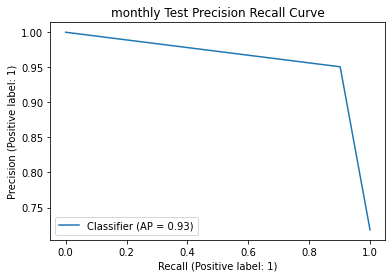

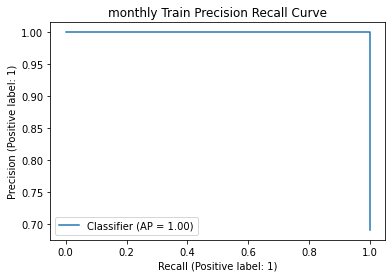

In [881]:
# plot PR Curve
reg_model_list["monthly"].makePRplot()
print('test results')
print(f' precision test {reg_model_list["monthly"].bigscoretest[0]}')
print(f' recall test {reg_model_list["monthly"].bigscoretest[1]}')
print(f' f1 test {reg_model_list["monthly"].bigscoretest[2]}')
print(f' support test {reg_model_list["monthly"].bigscoretest[3]}')
print('-----------------------------------------------------')
print('train results')
print(f' precision train {reg_model_list["monthly"].bigscoretrain[0]}')
print(f' recall train {reg_model_list["monthly"].bigscoretrain[1]}')
print(f' f1 train {reg_model_list["monthly"].bigscoretrain[2]}')
print(f' support train {reg_model_list["monthly"].bigscoretrain[3]}')


### Untuned Yearly

test results
 precision test 0.88
 recall test 0.9565217391304348
 f1 test 0.9166666666666666
 support test None
-----------------------------------------------------
train results
 precision train 1.0
 recall train 1.0
 f1 train 1.0
 support train None


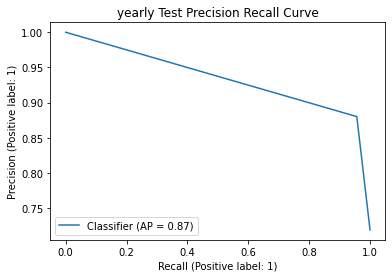

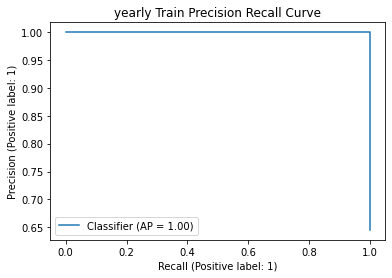

In [882]:
# plot PR Curve
reg_model_list["yearly"].makePRplot()
print('test results')
print(f' precision test {reg_model_list["yearly"].bigscoretest[0]}')
print(f' recall test {reg_model_list["yearly"].bigscoretest[1]}')
print(f' f1 test {reg_model_list["yearly"].bigscoretest[2]}')
print(f' support test {reg_model_list["yearly"].bigscoretest[3]}')
print('-----------------------------------------------------')
print('train results')
print(f' precision train {reg_model_list["yearly"].bigscoretrain[0]}')
print(f' recall train {reg_model_list["yearly"].bigscoretrain[1]}')
print(f' f1 train {reg_model_list["yearly"].bigscoretrain[2]}')
print(f' support train {reg_model_list["yearly"].bigscoretrain[3]}')


In [883]:
reg_stats_df.to_markdown(index=False)

'| model     |   precision_train |   recall_train |   f1_train |   auc_train |   precision_test |   recall_test |   f1_test |   auc_test |\n|:----------|------------------:|---------------:|-----------:|------------:|-----------------:|--------------:|----------:|-----------:|\n| monthly   |                 1 |              1 |          1 |           1 |         0.950739 |      0.901869 |  0.925659 |   0.927912 |\n| quarterly |                 1 |              1 |          1 |           1 |         0.903614 |      0.892857 |  0.898204 |   0.878227 |\n| yearly    |                 1 |              1 |          1 |           1 |         0.88     |      0.956522 |  0.916667 |   0.872989 |'

## Question 4
Resetting the random seed to 1, use RandomizedSearchCV to apply hyperparameter optimization on the train set. 

Does this improve the three performance metrics computed in #3 on the train and test sets? (24 points)



| model     |   precision_train |   recall_train |   f1_train |   auc_train |   precision_test |   recall_test |     f1_test |    auc_test |
|:----------|------------------:|---------------:|-----------:|------------:|-----------------:|--------------:|------------:|------------:|
| monthly   |        -0.0124378 |     -0.0352369 | -0.0239705 |  -0.0229076 |       0.00936083 |   -0.00233645 |  0.00317044 |  0.00787688 |
| quarterly |        -0.0248447 |     -0.0125786 | -0.01875   |  -0.0291108 |      -0.00237989 |   -0.0238095  | -0.0133551  | -0.00770985 |
| yearly    |        -0.0243902 |      0         | -0.0123457 |  -0.0243902 |       0.0765217  |    0          |  0.0398551  |  0.0731947  |

We see a decrese in the train set which is good in that it is highly suspect that in the original model that we were overfitting.

Monthly and quarterly test sets had increases in all three stats. Monthly had only a slight increase which is to be expected since monthly had enough data to make it a robust model.
Yearly had a very large increase of 7% for precision and auc as the tuning helped the relatively small dataset perform much better.

Quarterly is suprising in that there's a slight decrease through tuning. 


In [884]:
class tunedmodel(rfmodel):
    def __init__(self, name, data):
        super().__init__(name, data)
        self.basemodel = RandomForestClassifier(random_state=1)
        self.scorer = metrics.make_scorer(metrics.f1_score, needs_proba=True)
        self.tuner = RandomizedSearchCV(self.basemodel, param_distributions={'bootstrap': [True, False],
                                                                         'max_depth': [3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 100, 500, None],
                                                                         'min_samples_leaf': [1, 3, 5, 7, 9, 11, 13, 15],
                                                                         'min_samples_split': [2, 3, 5, 7, 9, 11, 13, 15],
                                                                         'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000],
                                                                         'criterion':['gini','entropy']},
                                                                         scoring=self.scorer, n_jobs=-1, cv=5, random_state=1)
        
    def tunerfit(self):
        self.model = self.tuner.fit(self.X_Train,self.Y_Train)
        self.Y_Pred_Train = self.model.predict(self.X_Train)
        self.Y_Pred_Test = self.model.predict(self.X_Test)
        self.train_probs = self.model.predict_proba(self.X_Train)
        self.test_probs = self.model.predict_proba(self.X_Test)
        self.train_probs = self.train_probs[:,1]
        self.test_probs = self.test_probs[:,1]
        self.precision_train, self.precision_train, self.train_threshold = metrics.precision_recall_curve(self.Y_Train, self.train_probs)
        self.precision_test, self.precision_test, self.test_threshold = metrics.precision_recall_curve(self.Y_Test, self.test_probs)
        self.auc_train = average_precision_score(self.Y_Train, self.Y_Pred_Train)
        self.auc_test = average_precision_score(self.Y_Test, self.Y_Pred_Test)

In [885]:
tuned_model_list = {}
for key, value in model_list.items():
    model = tunedmodel(key, value)
    model.tunerfit()
    model.getAccuracy()
    
    tuned_model_list[key] = model

tuned_stats_holder = []
for key, value in tuned_model_list.items():
    smallholder = {}
    smallholder['model'] = key
    smallholder['precision_train'] = value.bigscoretrain[0]
    smallholder['recall_train'] = value.bigscoretrain[1]
    smallholder['f1_train'] = value.bigscoretrain[2]
    smallholder['auc_train'] = value.auc_train
    smallholder['precision_test'] = value.bigscoretest[0]
    smallholder['recall_test'] = value.bigscoretest[1]
    smallholder['f1_test'] = value.bigscoretest[2]
    smallholder['auc_test'] = value.auc_test
    tuned_stats_holder.append(smallholder)

tuned_stats_df = pd.DataFrame(tuned_stats_holder)


c:\Users\tkkim\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_search.py:979: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(
c:\Users\tkkim\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_search.py:979: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(
c:\Users\tkkim\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_search.py:979: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


### Tuned Quarterly

test results
 precision test 0.9012345679012346
 recall test 0.8690476190476191
 f1 test 0.8848484848484849
 support test None
-----------------------------------------------------
train results
 precision train 0.9751552795031055
 recall train 0.9874213836477987
 f1 train 0.98125
 support train None


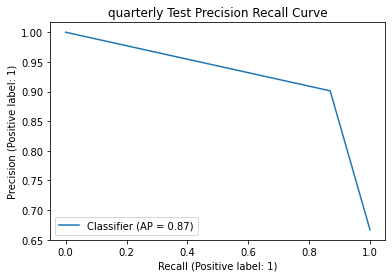

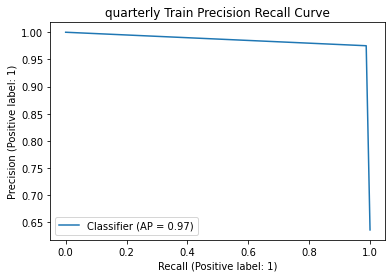

In [886]:
# plot PR Curve
tuned_model_list["quarterly"].makePRplot()
print('test results')
print(f' precision test {tuned_model_list["quarterly"].bigscoretest[0]}')
print(f' recall test {tuned_model_list["quarterly"].bigscoretest[1]}')
print(f' f1 test {tuned_model_list["quarterly"].bigscoretest[2]}')
print(f' support test {tuned_model_list["quarterly"].bigscoretest[3]}')
print('-----------------------------------------------------')
print('train results')
print(f' precision train {tuned_model_list["quarterly"].bigscoretrain[0]}')
print(f' recall train {tuned_model_list["quarterly"].bigscoretrain[1]}')
print(f' f1 train {tuned_model_list["quarterly"].bigscoretrain[2]}')
print(f' support train {tuned_model_list["quarterly"].bigscoretrain[3]}')


### Tuned Monthly

test results
 precision test 0.9600997506234414
 recall test 0.8995327102803738
 f1 test 0.9288299155609168
 support test None
-----------------------------------------------------
train results
 precision train 0.9875621890547264
 recall train 0.9647630619684082
 f1 train 0.9760295021511985
 support train None


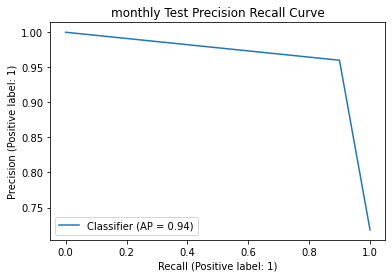

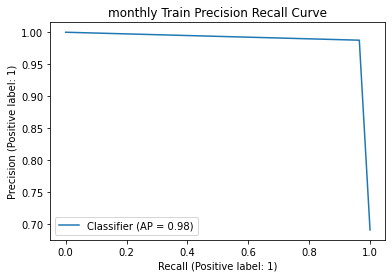

In [887]:
# plot PR Curve
tuned_model_list["monthly"].makePRplot()
print('test results')
print(f' precision test {tuned_model_list["monthly"].bigscoretest[0]}')
print(f' recall test {tuned_model_list["monthly"].bigscoretest[1]}')
print(f' f1 test {tuned_model_list["monthly"].bigscoretest[2]}')
print(f' support test {tuned_model_list["monthly"].bigscoretest[3]}')
print('-----------------------------------------------------')
print('train results')
print(f' precision train {tuned_model_list["monthly"].bigscoretrain[0]}')
print(f' recall train {tuned_model_list["monthly"].bigscoretrain[1]}')
print(f' f1 train {tuned_model_list["monthly"].bigscoretrain[2]}')
print(f' support train {tuned_model_list["monthly"].bigscoretrain[3]}')


### Tuned Yearly

test results
 precision test 0.9565217391304348
 recall test 0.9565217391304348
 f1 test 0.9565217391304348
 support test None
-----------------------------------------------------
train results
 precision train 0.975609756097561
 recall train 1.0
 f1 train 0.9876543209876543
 support train None


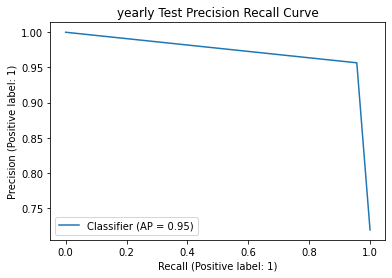

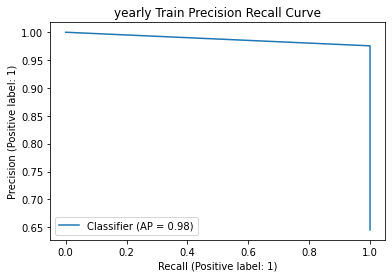

In [888]:
# plot PR Curve
tuned_model_list["yearly"].makePRplot()
print('test results')
print(f' precision test {tuned_model_list["yearly"].bigscoretest[0]}')
print(f' recall test {tuned_model_list["yearly"].bigscoretest[1]}')
print(f' f1 test {tuned_model_list["yearly"].bigscoretest[2]}')
print(f' support test {tuned_model_list["yearly"].bigscoretest[3]}')
print('-----------------------------------------------------')
print('train results')
print(f' precision train {tuned_model_list["yearly"].bigscoretrain[0]}')
print(f' recall train {tuned_model_list["yearly"].bigscoretrain[1]}')
print(f' f1 train {tuned_model_list["yearly"].bigscoretrain[2]}')
print(f' support train {tuned_model_list["yearly"].bigscoretrain[3]}')


In [889]:
reg_stats_df.set_index('model', inplace=True)
tuned_stats_df.set_index('model', inplace=True)

In [890]:
tuned_stats_df

,precision_train,recall_train,f1_train,auc_train,precision_test,recall_test,f1_test,auc_test
model,,,,,,,,
monthly,0.987562,0.964763,0.976030,0.977092,0.960100,0.899533,0.928830,0.935789
quarterly,0.975155,0.987421,0.981250,0.970889,0.901235,0.869048,0.884848,0.870517
yearly,0.975610,1.000000,0.987654,0.975610,0.956522,0.956522,0.956522,0.946184


In [891]:
diff_df = tuned_stats_df.subtract(reg_stats_df)

In [892]:
diff_df.to_markdown()

'| model     |   precision_train |   recall_train |   f1_train |   auc_train |   precision_test |   recall_test |     f1_test |    auc_test |\n|:----------|------------------:|---------------:|-----------:|------------:|-----------------:|--------------:|------------:|------------:|\n| monthly   |        -0.0124378 |     -0.0352369 | -0.0239705 |  -0.0229076 |       0.00936083 |   -0.00233645 |  0.00317044 |  0.00787688 |\n| quarterly |        -0.0248447 |     -0.0125786 | -0.01875   |  -0.0291108 |      -0.00237989 |   -0.0238095  | -0.0133551  | -0.00770985 |\n| yearly    |        -0.0243902 |      0         | -0.0123457 |  -0.0243902 |       0.0765217  |    0          |  0.0398551  |  0.0731947  |'